# Histopathologic Cancer Detection
Cancer detection is an important area in the field of biomedical data science. AI-assisted classification of tissues can help physicians detect cancerous tissues, preventing false negatives and speeding up medical diagnostics. Here, we utilize Convolutional Neural Networks (CNNs) to help classify the cancer tissue. We will train and evaluate a number of CNN architectures. Specifically, we will utilize an architecture inspired by LeNet-5. LeNet-5 classically inputs a $32 \times 32$ image through a series of convolutions and average pooling layers. This is followed by a series of dense layers which ultimately classify each sample. This work is done in part of *Kaggle's Histopathologic Cancer Detection* competition.

This work can be found the respective github repository: https://github.com/benjamin-ahlbrecht/histopathologic-caner-detection

A series of approximately $220,000\:$ $96 \times 96$ `.tif` images of tissue are accompanied by labels, where a $0$ corresponds to a label with no cancer and a $1$ corresponds to a label where cancer is detected. Importantly, the labeling decision is made based on whether there exists cancerous tissue in the $32 \times 32$ area in the center of each image. Consequently, we will first crop the images prior to feeding them into the model. This will exponentially reduce the number of trainable parameters, significantly improving training time without sacrificing classification performance. To ensure our first convolutional layer will not lose edge information, we will adding $4$ pixels of padding on either side, resulting in a $36 \times 36$ image.

## Data Downloading
To download the training and testing data, we can utilize the `kaggle` CLI. Python's package manager, `pip`, is used to install this. *If you are running this, you will have to have to authenticate your client by creating and downloading an API token found under your Kaggle account settings*.

In [ ]:
%%bash
%%time
# Download and unzip the kaggle competition
mkdir data
cd data

printf "Downloading the HistoPathologic Cancer Detection Dataset\n"
kaggle competitions download -c histopathologic-cancer-detection

printf "Unzipping the Dataset\n"
unzip histopathologic-cancer-detection.zip

In [4]:
%%bash
cd data

pwd
du --block-size=G

echo ""
ls -la

/home/benjamin/Git/histopathologic-caner-detection/src/data
1G	./train/.ipynb_checkpoints
1G	./train/.comments
6G	./train
2G	./test
14G	.

total 6721684
drwxr-xr-x 4 benjamin benjamin       4096 Sep  1 20:13 .
drwxr-xr-x 6 benjamin benjamin       4096 Sep 19 14:13 ..
-rw-r--r-- 1 benjamin benjamin 6773228425 Sep  1 09:57 histopathologic-cancer-detection.zip
-rw-r--r-- 1 benjamin benjamin   76607678 Sep  1 20:13 Miniconda3-latest-Linux-x86_64.sh
-rw-r--r-- 1 benjamin benjamin    2470703 Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 benjamin benjamin    4329472 Sep  1 09:57 test
drwxr-xr-x 4 benjamin benjamin   16805888 Sep  1 11:11 train
-rw-r--r-- 1 benjamin benjamin    9461084 Dec 12  2019 train_labels.csv


## Data Source and Ingestion 
Here, we perform some necessary preliminary actions: loading packages, obtaining the directory and file paths for the source directory, the data directory, the data training directory, the data testing directory, and the metadata files containing the training labels for each respective training image. The `train_labels.csv` is loaded in as a Pandas dataframe, and we append the full path of the image to the dataframe to streamline data ingestion.

In [5]:
%load_ext autoreload
%autoreload 2

In [180]:
# Linear Algebra / Arrays
import numpy as np

# Dataframes and data I/O
import pandas as pd

# File system I/O
import os

# Image processing
from PIL import Image

# Plotting capabilities
from matplotlib import pyplot as plt
import altair as alt

# ML/DL
import tensorflow as tf
from tensorflow import keras

# Multiprocesssing
import concurrent.futures
from itertools import repeat

# Hyperparameter tuning
import keras_tuner as kt

np.set_printoptions(precision=3)

In [50]:
# Obtain relevant paths
DIR_SRC = os.getcwd()
DIR_DATA = f"{DIR_SRC}/data"
DIR_DATA_TRAIN = f"{DIR_DATA}/train"
DIR_DATA_TEST = f"{DIR_DATA}/test"

# Store the location of our training labels dataset
FILE_METADATA_TRAIN = f"{DIR_DATA}/train_labels.csv"

In [52]:
print(f"""\
Source Directory:     {DIR_SRC}
Data Directory:       {DIR_DATA}
Data Train Directory: {DIR_DATA_TRAIN}
Data Test Directory:  {DIR_DATA_TEST}
Training Labels File: {FILE_METADATA_TRAIN}
""")

Source Directory:     /home/benjamin/Git/histopathologic-caner-detection/src
Data Directory:       /home/benjamin/Git/histopathologic-caner-detection/src/data
Data Train Directory: /home/benjamin/Git/histopathologic-caner-detection/src/data/train
Data Test Directory:  /home/benjamin/Git/histopathologic-caner-detection/src/data/test
Training Labels File: /home/benjamin/Git/histopathologic-caner-detection/src/data/train_labels.csv



In [9]:
# Load in the training labels as a pandas dataframe
METADATA_TRAIN = pd.read_csv(FILE_METADATA_TRAIN)

# Add in the full path to the id, so we can grab it easier
METADATA_TRAIN["path"] = DIR_DATA_TRAIN + "/" + METADATA_TRAIN["id"] + ".tif"

In [10]:
METADATA_TRAIN.head(10)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/benjamin/Git/histopathologic-caner-detec...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/benjamin/Git/histopathologic-caner-detec...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/benjamin/Git/histopathologic-caner-detec...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/benjamin/Git/histopathologic-caner-detec...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/benjamin/Git/histopathologic-caner-detec...
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0,/home/benjamin/Git/histopathologic-caner-detec...
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,/home/benjamin/Git/histopathologic-caner-detec...
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,/home/benjamin/Git/histopathologic-caner-detec...
8,559e55a64c9ba828f700e948f6886f4cea919261,0,/home/benjamin/Git/histopathologic-caner-detec...
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0,/home/benjamin/Git/histopathologic-caner-detec...


## Exploratory Data Analysis
An exploratory data analysis on images may be difficult to perform. However, there are a few things we can do to ensure that model building will go well: We can display random images alongside their label to gain an intuitive idea of what we are trying to achieve, and we can plot a histogram of the training label frequencies to see how much data we actually have and how balanced our classes are. The Kaggle competition indicates a sample as positive for cancer if there exists cancerous tissue in a $32 \times 32$ pixel region at the center of the image. To emphasize this, we will highlight the area in our visualizations.

In [11]:
def tif_to_numpy(fname):
    """Load a .tif image as a NumPy array given the file name.
    
    Parameters
    ----------
    fname: string
        The input string for the .tif image
    
    Returns
    -------
    image: np.ndarray
        The 3D NumPy array corresponding to the iamge
    """
    # Load the tif as an Image
    image = Image.open(fname)
    return np.array(image)


def extract_sub_square_mask(arr, l):
    """Extracts a sub-square mask from a square NumPy array of size
    (l x l x ...), wherein all values are 0 except the square of length l in
    the center.
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to sub-square mask.
    l: int
        The desired side-length of the center square to mask
        
    Returns
    -------
    arr_mask: np.ndarray
        The sub-squared and masked NumPy array. All values are False except the
        elements present in the sub-square.
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_mask = np.full((n, n), False)
    arr_mask[start:end, start:end] = True
    
    return arr_mask


def extract_sub_square(arr, l):
    """Extacts a sub-square from a square NumPy array of size
    (l x l x ...).
    
    Parameters
    ----------
    arr: np.ndarray
        The square NumPy array to subset.
    l: int
        The desired side-length of the center square to extract.
    
    Returns
    -------
    arr_sub: np.ndarray
        The sub-squared array
    """
    n = arr.shape[0]
    
    start = n - (l * 2)
    end = n - l
    
    arr_sub = arr[start:end, start:end]
    return arr_sub
    


def display_random_images(metadata_train, n=3):
    """Display n*n random images as a matplotlib figure from the train_csv dataframe
    
    Parameters
    ----------
    metadata_train: list of strings
        The input metadata
        
    n: int
        The number of images to select for a row. A total of n^2 images will be
        selected.
    """
    n2 = n * n
    indices = random.sample(range(n2), n2)
    
    # Extract the images and their label
    image_labels = [metadata_train["label"][i] for i in indices]
    
    # Load in the images
    images = [tif_to_numpy(metadata_train["path"][i]) for i in indices]
    
    # Display each image in a subplot
    fig, ax = plt.subplots(figsize=(3.5*n, 3.5*n), ncols=n, nrows=n, tight_layout=True)
    
    # Generate a mask to detect the center of the image
    mask = extract_sub_square_mask(images[0], 32)
    print(mask.shape)
    
    # k will serve as a pointer to our image and label
    k = 0
    
    for i in range(n):
        for j in range(n):
            # Plot the individual image in an axis
            image = images[k]
            image[~mask] = image[~mask] * 0.5
            
            # Highlight the center 32 x 32 region
            ax[i, j].axis("off")
            ax[i, j].imshow(image)
            ax[i, j].set_title(f"Label: {image_labels[k]}")
            
            k += 1

(96, 96)


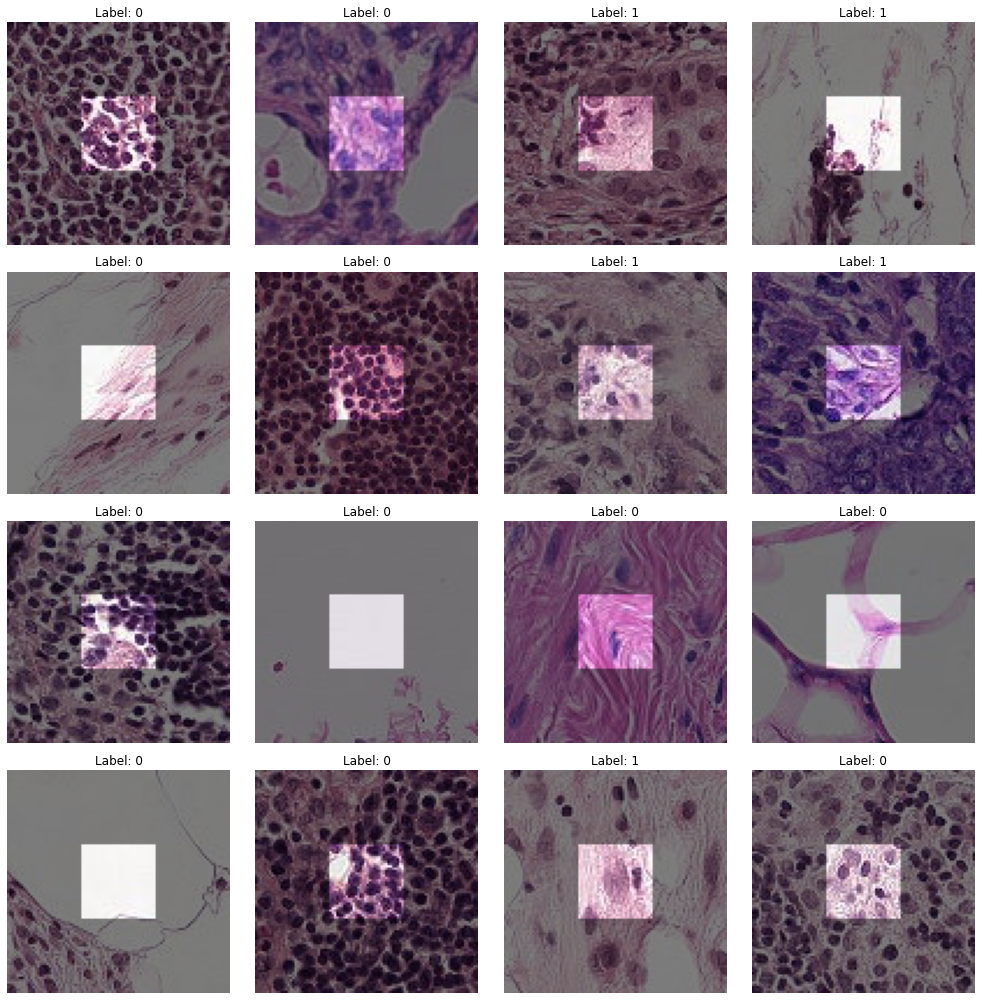

In [12]:
display_random_images(METADATA_TRAIN, n=4)

In [13]:
# Generate a figure to determine the distribution of training labels
source = pd.DataFrame({
    "Label": ["0 (No Cancer)", "1 (Cancer)"],
    "Count": [sum(METADATA_TRAIN["label"] == 0), sum(METADATA_TRAIN["label"] == 1)]
})


(
    alt.Chart(source)
    .mark_bar()
    .encode(
        x=alt.X("Label:O", axis=alt.Axis(labelAngle=0)),
        y=alt.Y("Count:Q")
    )
    .properties(width=500, height=300)
)

alt.Chart(...)

## Data Preprocessing
We will utilize TensorFlow datasets to preprocess our data. Image data will benefit from normalization and will require shuffling to ensure that the data is i.i.d. We will also split the training data to include a validation set to help tune our CNN models.

In [14]:
# Create the full dataset of the metadata
IMAGE_PATHS = METADATA_TRAIN["path"]
IMAGE_LABELS = np.array(METADATA_TRAIN["label"]).reshape(-1, 1)

# Define how many samples compose a single epoch (buffer)
n = len(IMAGE_PATHS)

buffer_size = 10_000

if buffer_size is None:
    buffer_size = n
    
# Define how we will split the dataset
train_proportion = 0.75
train_size = np.floor(n * train_proportion)

assert buffer_size <= train_size,\
    f"Buffer size ({buffer_size}) must be smaller than the train size ({train_size})"

# Define the image size to feed into the CNN
# Labels are assigned based on (32 x 32) square; add some padding for convolutions
padding = 4
image_length = 32 + padding

print(f"""\
Size of Dataset:       {n}
Buffer Size:           {buffer_size}
Train Proportion:      {train_proportion}
Train Size:            {train_size}
Validation Proportion: {1 - train_proportion}
Validation Size:       {np.floor(buffer_size * (1 - train_proportion))}
Image Padding:         {padding}
Image Size:            {image_length} x {image_length}
""")


# Create a data generator that we can feed the dataset individual samples without running out of RAM
def image_generator(image_length=32):
    """Utilize the IMAGE_PATHS and IMAGE_LABELS global variables to load images
    in a generator form. This avoids memory overflow from processing all images
    at once.
    
    Parameters
    ----------
    image_length: int
        The side of a single side length to subset the image.
        
    Returns
    -------
    image: np.ndarray
        The resulting image in the form of a NumPy array. 
    """
    for path, label in zip(IMAGE_PATHS, IMAGE_LABELS):
        image = tif_to_numpy(path)
        image = extract_sub_square(image, image_length)
        yield (image, label)
        

# TODO: apply image_z = (image - mean(image) / std(image))... Tensors are hard
def normalization(image):
    """Normalize an image across each RGB channel using the z-score.
    
    Parameters
    ----------
    image : tf.tensor
        The input image
    
    Returns
    -------
    image_z : tf.tensor
        The z-score normalized image
    """ 
    image_z = image / 255
    
    return image_z

Size of Dataset:       220025
Buffer Size:           10000
Train Proportion:      0.75
Train Size:            165018.0
Validation Proportion: 0.25
Validation Size:       2500.0
Image Padding:         4
Image Size:            36 x 36



In [16]:
# Create our full dataset, which we cache after loading, cropping, and normalizing the image
dataset_full = (
    tf.data.Dataset.from_generator(
        lambda: image_generator(image_length),
        output_signature=(
            tf.TensorSpec(shape=(image_length, image_length, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.int16)
        )
    )
    .map(
        lambda x, y: (normalization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .shuffle(len(IMAGE_LABELS))
)



# Split the dataset into a training set, take batches, and prefetch for training
dataset_train = (
    dataset_full.take(train_size)
    .cache()
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


# Do the same thing to produce a validation set
dataset_validation = (
    dataset_full.skip(train_size)
    .cache()
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

## Model Architecture and Building
Here, we implement the modified LeNet-5 model as discussed above. LeNet-5 is composed of an input layer of size $32 \times 32$. Since our image is $96 \times 96$ and classsification if based on the $32 \times 32$ pixel square in the center, we utilize an input size of $36 \times 36$ to ensure we do not lose any edge information during our convolutions. LeNet-5 follows this through a series of $5 \times 5$ convolutions with a stride of $1 \times 1$. Classically, LeNet-5 utilizes 6 filters in the first convolution and 16 layers in the second convolution. Increasing the number of filters allows us to extract more fine-grained or local information from the image. We will use 12 layers in the second convolution rather than 16 since our image is not greyscale. This will help improve training time. Additionally, we will use the standard ReLU activation function rather than the sigmoid or tanh activation that LeNet-5 would use, which should improve model performance and training time. Inbetween each convolution is an average pooling layer which reduces the dimensionality of the feature maps by $50\%$. After the second average pool, we flatten the feature map before feeding it into a fully-connected ANN. The ANN is composed of 3 layers with a decreasing number of neurons: 120 neurons to 40 neurons to only a single neuron for cancer classsification.

Since this is a binary classification problem, we will utilize binary cross entropy as a loss function. We will use the *Adam gradient descent* for back-propogation, which improves on ordinary gradient descent by keeping track of the error surface's moments to ensure that we move down the surface smoothly. Finally, since the competition is graded based on AUC, we keep track of the AUC. Since the classes are relatively balanced, the accuracy should also be a useful metric. To avoid overfitting, we utilize early stopping and monitor the validation AUC with a patience of 3. This means that if our validation AUC does not improve after 3 epochs, we will stop learning and return the model with the highest validation AUC.

![lenet5](assets/lenet5.png)

In [24]:
def lenet_builder(hp):
    # Define our hyper-parameter space
    hp_units_d1 = hp.Choice("units_d1", values=[64, 96, 128])
    hp_units_d2 = hp.Choice("units_d2", values=[32, 64])
    hp_lr = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    
    lenet = keras.Sequential([
        keras.layers.Input((36, 36, 3)),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation="relu"),
        keras.layers.AveragePooling2D(),

        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), activation="relu"),
        keras.layers.AveragePooling2D(),

        keras.layers.Flatten(),

        keras.layers.Dense(units=hp_units_d1, activation="relu"),
        keras.layers.Dense(units=hp_units_d2, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])

    lenet.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"]
    )
    
    return lenet
    

callback = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    restore_best_weights=True
)

## Hyperparameter Tuning
Recently, the *Hyperband* algorithm for hyperparameter tuning was revealed. The paper describing the algorithm can be found [here](https://jmlr.org/papers/volume18/16-558/16-558.pdf) and the Keras documentation can be found [here](https://keras.io/api/keras_tuner/tuners/hyperband/). Due to the cost of hyper-parameter tuning, we restrict ourselves to altering the fully-connected layers and the initial learning rate for the *Adam* optimizer.

In [27]:
# Define our hyperparameter tuner
tuner = kt.Hyperband(
    lenet_builder,
    objective="val_loss",
    max_epochs=5,
    factor=3
)

In [28]:
# Perform the hyperparameter search
tuner.search(
    dataset_train,
    epochs=10,
    verbose=1,
    callbacks=[callback],
    validation_data=dataset_validation,
)

Trial 10 Complete [00h 05m 34s]
val_loss: 0.46585285663604736

Best val_loss So Far: 0.4273313283920288
Total elapsed time: 00h 40m 47s
INFO:tensorflow:Oracle triggered exit


In [31]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best architecture
lenet = tuner.hypermodel.build(best_hps)

lenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 12)        1812      
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 12)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 432)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [39]:
print("HYPERPARAMETER SELECTIONS")
print(f"Dense Layer 1 Neurons: {best_hps.get('units_d1')}")
print(f"Dense Layer 2 Neurons: {best_hps.get('units_d2')}")
print(f"Learning Rate (ADAM):  {best_hps.get('learning_rate')}")

HYPERPARAMETER SELECTIONS
Dense Layer 1 Neurons: 128
Dense Layer 2 Neurons: 32
Learning Rate (ADAM):  0.001


## Model Training And Validation
Here, we fit the neural network with the training data. A random training and validation split is created each epoch. Selecting random training and validation will help prevent the model from overfitting on the training data. As stated before, we keep track of the AUC and accuracy for the validation and training sets. To examine model performance over time, we plot the metrics over each epoch.

In [40]:
%%time
history = lenet.fit(
    dataset_train,
    epochs=50,
    verbose=1,
    callbacks=[callback],
    validation_data=dataset_validation
)

Epoch 1/50
2579/2579 [==============================] - 66s 25ms/step - loss: 0.5130 - accuracy: 0.7549 - auc: 0.8165 - val_loss: 0.4785 - val_accuracy: 0.7838 - val_auc: 0.8465
Epoch 2/50
2579/2579 [==============================] - 65s 25ms/step - loss: 0.4683 - accuracy: 0.7851 - auc: 0.8499 - val_loss: 0.4510 - val_accuracy: 0.7934 - val_auc: 0.8642
Epoch 3/50
2579/2579 [==============================] - 65s 25ms/step - loss: 0.4518 - accuracy: 0.7941 - auc: 0.8614 - val_loss: 0.4366 - val_accuracy: 0.8034 - val_auc: 0.8757
Epoch 4/50
2579/2579 [==============================] - 65s 25ms/step - loss: 0.4420 - accuracy: 0.7995 - auc: 0.8677 - val_loss: 0.4378 - val_accuracy: 0.8021 - val_auc: 0.8729
Epoch 5/50
2579/2579 [==============================] - 65s 25ms/step - loss: 0.4329 - accuracy: 0.8047 - auc: 0.8736 - val_loss: 0.4321 - val_accuracy: 0.8052 - val_auc: 0.8827
Epoch 6/50
2579/2579 [==============================] - 65s 25ms/step - loss: 0.4264 - accuracy: 0.8083 - auc:

In [47]:
# Save the model to our ./model/ directory
lenet.save("./model/lenet_cancer_model.tf")

INFO:tensorflow:Assets written to: ./model/lenet_cancer_model.tf/assets


In [48]:
# Create a dataframe from the training history
source = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={
        "index": "Epoch",
        "loss": "Loss",
        "accuracy": "Accuracy",
        "auc": "AUC",
        "val_loss": "Validation Loss",
        "val_accuracy": "Validation Accuracy",
        "val_auc": "Validation AUC"
    })
)

source["Epoch"] += 1


# Melt the data for multi-series plotting
source_melt = source.melt(id_vars="Epoch")

display(source)
display(source_melt)

,Epoch,Loss,Accuracy,AUC,Validation Loss,Validation Accuracy,Validation AUC
0,1,0.513015,0.754936,0.816462,0.478451,0.783773,0.846536
1,2,0.468305,0.785145,0.849873,0.451028,0.793390,0.864169
2,3,0.451839,0.794089,0.861412,0.436609,0.803389,0.875654
3,4,0.441977,0.799513,0.867719,0.437759,0.802098,0.872924
4,5,0.432914,0.804682,0.873630,0.432143,0.805188,0.882749
5,6,0.426375,0.808342,0.877668,0.416263,0.813551,0.884202
6,7,0.421726,0.811051,0.880533,0.414598,0.814824,0.885087
7,8,0.417242,0.812196,0.883282,0.411270,0.816169,0.887334
8,9,0.412580,0.815438,0.886021,0.411529,0.818169,0.887031
9,10,0.406324,0.819402,0.889742,0.405338,0.819168,0.891105


,Epoch,variable,value
0,1,Loss,0.513015
1,2,Loss,0.468305
2,3,Loss,0.451839
3,4,Loss,0.441977
4,5,Loss,0.432914
...,...,...,...
187,28,Validation AUC,0.917091
188,29,Validation AUC,0.923211
189,30,Validation AUC,0.922769
190,31,Validation AUC,0.923184


In [49]:
c1 = (
    alt.Chart(source.melt(["Epoch"], ["Loss", "Validation Loss"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Loss (Binary Cross Entropy)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c2 = (
    alt.Chart(source.melt(["Epoch"], ["Accuracy", "Validation Accuracy"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="Accuracy", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)

c3 = (
    alt.Chart(source.melt(["Epoch"], ["AUC", "Validation AUC"]))
    .mark_line(point=alt.OverlayMarkDef())
    .encode(
        x=alt.X("Epoch", type="ordinal"),
        y=alt.Y("value", type="quantitative", title="AUC (Area Under Curve)", scale=alt.Scale(domain=[0, 1])),
        color=alt.Color("variable"),
        strokeDash="variable"
    )
    .properties(
        height=250,
        width=400,
    )
)


c4 = (
    alt.hconcat(c1, c2, c3)
    .resolve_scale(color="independent", strokeDash="independent")
    .configure_view(stroke=None)
)

display(c4)

alt.HConcatChart(...)

## Model Testing
We now have a finely-tuned LeNet-5-inspired model. We can make predictions on the images in `./data/test/`. The corresponding labels will be assigned to a dataframe before they are converted to a `.csv` file for submission results. An image pipeline will be established, so we can efficiently transform the testing image into a prediction label. The pipeline steps are below:
1. Load in image
2. Crop image
3. Normalize image
4. Feed image into model
5. Make prediction
6. Round prediction to the nearest integer
7. Return the prediction

In [146]:
def image_pipeline(fpath, image_length):
    """Read in an image, crop and normalize it as a NumPy array
    
    Parameters
    ----------
    fpath: str
        The file path location of the image
    image_length: int
        The side length of the image after being cropped with PIL
        
    Returns
    -------
    image_normalized: np.ndarray
        The cropped and normalized image
    """
    image = tif_to_numpy(fpath)
    image_cropped = extract_sub_square(image, image_length)
    image_normalized = normalization(image_cropped)
    return image_normalized

def read_images(fpaths, image_lengths):
    """Read in an iterable of image paths and return a array of images.
    
    Parameters
    ----------
    fpaths: iterable of strings
        The file path locations of the images
    image_lengths: int
        The side length of the image after being cropped with PIL
    
    Returns
    -------
    images: np.ndarray
        A array of images of size (n_im, l_im, l_im, 3)
    """
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(image_pipeline, fpaths, repeat(image_lengths))
    
    images = np.array(list(results))
    return images

In [148]:
%%time
# Collect all test images
METADATA_TEST = [f"{DIR_DATA_TEST}/{f}" for f in os.listdir(DIR_DATA_TEST) if f.endswith(".tif")]

# Convert the images to images
x_test = read_images(METADATA_TEST, image_length)
print(x_test.shape)

(57458, 36, 36, 3)
CPU times: user 20.2 s, sys: 6.1 s, total: 26.3 s
Wall time: 29.2 s


In [153]:
# Make predictions on the images
predictions = lenet(x_test).numpy()

In [161]:
# Round the predictions to the nearest integer for classification
predictions_class = predictions.round().astype(int)

## Model Submission
With test predictions made, we must submit the observations to Kaggle for evaluation. We simply use a function that wraps the predictions and file paths into a dataframe. The dataframe is converted to a .csv which we can submit utilizing the `kaggle` CLI. The function is a generator to ensure that the file path is not overwritten.

In [171]:
def make_submission_csv(fpaths, predictions_class, outname):
    """Prepare image filepaths and their corresponding prediction class for
    Kaggle submission.
    
    Parameters
    ----------
    fpaths: iterable of strings
        The filenames of the images
    predictions_class: np.ndarray of ints
        The output predictions corresponding to the file paths
    outname: str
        The output name of the .csv file
    
    Returns
    -------
    df: pd.DataFrame
        The submission dataframe
    """
    # Prune the fpaths to exclude the .tif, retrieving the id
    ids = [fpath[:-4] for fpath in fpaths]
    
    # Create a dataframe to prepare our data
    df = pd.DataFrame({"id": ids, "label": predictions_class.flatten()})
    
    # Convert the dataframe to a csv
    df.to_csv(outname, index=False)

    return df

In [173]:
id_files = [fpath for fpath in os.listdir(DIR_DATA_TEST) if fpath.endswith(".tif")]
submission_fname = "submissions/submission.csv"

make_submission_csv(id_files, predictions_class, submission_fname)

,id,label
0,531f83ad8fa6a3657a46c80758dbd89b82533097,0
1,4a66b20bc810298a4077d338a8405a86db314cf5,0
2,98cd10bb06d1dce9333dfeb26f80e08ccc649fec,0
3,155b2b44dbd3aaedccbd2a0057997388b4159e5e,0
4,1ebb3f5a5f970020972e5ffb2cb91ea6d8e55141,1
...,...,...
57453,23d1be8ff435fd31ee5144c43db28426d7123564,0
57454,4ad61796dd15162882cad442a28dfef6a2585d2e,0
57455,8396bc73aa9d9fe59af41b0f54cb594c3b9d9c97,1
57456,1ceb6ad37a9126606d4732dd664397fdec161a15,0


In [177]:
%%bash
# Submit the results
kaggle competitions submit -c "histopathologic-cancer-detection" -f "submissions/submission.csv" -m "lenet-5 inspired model"

100%|██████████| 2.36M/2.36M [00:02<00:00, 986kB/s] 


Successfully submitted to Histopathologic Cancer Detection

![Kaggle Submission](assets/submission.png)

## Conclusion and Discussion
In the end, the LeNet inspired model achieved a score of only $0.7516$. There are a number of potential ways in which the score could be improved, to-which the remainder of this discussion will be based around. First, as I wanted to develop experience with the `kaggle` API, I attempted to train all models on my personal computer. This, in many ways, helped me think about how to extract the most performance out of a model due to the lack of GPU training. As such, significant hyper-parameter tuning could not be performed and a simpler model architecture was required. Speaking of the model architecture, LeNet was debued in 1998, and was designed around MNIST digit classification. Cancer detection, no doubt is significantly more complex than digit classification. I believe there are a number of ways to improve this model. A deeper architecture would help the model extract more local features that may be important to cancer detection. Here, we used average pooling to downsample our feature maps created from convolutions. We could potentially extract more performance from the model (at the cost of increased training time) by downsampling with a convolutional layer with a large stride. It is very likely that the neural network overfitted to the training data because we did not shuffle samples between training and validation sets. Moreover, regularization techniques such as dropout could be added to regularize the model. Dropout would esssentially train an ensemble of models with slightly increased training time. The LeNet-5 architecture, interestingly, utilizes $5 \times 5$ convolutions. If we added multiple $3 \times 3$ convolutionss in place of the $5 \times 5$ convolutions, we could likely extract better performance without increasing training time. Overall, this score represents a very simple model, and it could be improved with the use of a deeper architecture, regularization techniques, smaller convolutions, and better dataset management.